# タイタニックデータを用いた数量化理論

## ライブラリのインポート

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

## データ読み込み

In [4]:
df = pd.read_csv("dataset/titanic/train.csv")
df = df.dropna() # 今回欠損値は削除する
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [5]:
# 今回はカテゴリカラムを使用するので、量的変数は削除
x1 = pd.get_dummies(df.drop(["PassengerId", "Survived","Pclass","Name", "Age", "Fare", "Ticket", "Cabin"], axis=1), drop_first = True)
x1.head()

,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
1,1,0,False,False,False
3,1,0,False,False,True
6,0,0,True,False,True
10,1,1,False,False,True
11,0,0,False,False,True


In [6]:
x1[["Sex_male", "Embarked_Q", "Embarked_S"]] = x1[["Sex_male", "Embarked_Q", "Embarked_S"]].astype(int)
x1.head()

,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
1,1,0,0,0,0
3,1,0,0,0,1
6,0,0,1,0,1
10,1,1,0,0,1
11,0,0,0,0,1


In [7]:
x1.columns

Index(['SibSp', 'Parch', 'Sex_male', 'Embarked_Q', 'Embarked_S'], dtype='object')

## 数量化Ⅰ類

### 年齢を分析

In [32]:
y1 = df["Age"]
model1 = sm.OLS(y1, x1).fit() # Ordinary Least Squares (最小二乗法)
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Age   R-squared (uncentered):                   0.649
Model:                            OLS   Adj. R-squared (uncentered):              0.639
Method:                 Least Squares   F-statistic:                              65.74
Date:                Tue, 11 Feb 2025   Prob (F-statistic):                    1.25e-38
Time:                        08:40:19   Log-Likelihood:                         -834.08
No. Observations:                 183   AIC:                                      1678.
Df Residuals:                     178   BIC:                                      1694.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SibSp          6.6226      2.725      2.430      0.016       1.245      12.000
Parch          0.4254      2.352      0.181      0.857      -4.216       5.066
Sex_male      23.0024      3.029      7.593      0.000      17.024      28.981
Embarked_Q    17.0649     17.084      0.999      0.319     -16.649      50.778
Embarked_S    18.7679      3.008      6.240      0.000      12.833      24.703
==============================================================================
Omnibus:                        2.392   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                2.002
Skew:                          -0.237   Prob(JB):                        0.368
Kurtosis:                       3.197   Cond. No.                         12.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def quantification_ii(df, target_col, feature_cols):
    # カテゴリカル変数をダミー変換
    X = pd.get_dummies(df[[target_col] + feature_cols])
    target_dummies = [col for col in X.columns if col.startswith(target_col + "_")]
    # dependent_vars = [col for col in X.columns if col not in X[target_col].unique()]
    dependent_vars = [col for col in X.columns if col not in target_dummies]

    
    # 共分散行列の計算
    S_tot = X[dependent_vars].cov(ddof=0)
    
    # 各クラスのデータ数
    class_counts = {cls: X[f'{target_col}_{cls}'].sum() for cls in df[target_col].unique()}
    
    # 各クラスの共分散行列
    S_class = {cls: X[X[f'{target_col}_{cls}'] == 1][dependent_vars].cov(ddof=0) for cls in df[target_col].unique()}
    
    # 群内共分散行列と群間共分散行列
    N_total = sum(class_counts.values())
    S_within = sum(class_counts[cls] * S_class[cls] for cls in class_counts) / N_total
    S_between = S_tot - S_within
    
    # 固有値・固有ベクトル
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_tot).dot(S_between))
    idx_eta_square = np.argmax(eig_vals)
    qualitization_vector = eig_vecs[:, idx_eta_square]
    
    # y値の計算
    df_with_y = pd.concat([df[[target_col]], X[dependent_vars]], axis=1)
    df_with_y['y'] = X[dependent_vars].dot(qualitization_vector)
    
    # 符号調整
    y_means = df_with_y.groupby(target_col, observed=False)['y'].mean()
    if y_means.iloc[0] < y_means.iloc[-1]:
        qualitization_vector = -1 * qualitization_vector
        df_with_y['y'] = - df_with_y['y']
    
    # 分布をプロット
    for cls in df[target_col].unique():
        plt.hist(df_with_y[df_with_y[target_col] == cls]['y'], alpha=0.3, label=cls)
    
    plt.legend()
    plt.show()
    
    return df_with_y, qualitization_vector


In [44]:
df = pd.read_csv("dataset/titanic/train.csv")
df = df.dropna() # 今回欠損値は削除する
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     183 non-null    int64  
 2   Pclass       183 non-null    int64  
 3   Name         183 non-null    object 
 4   Sex          183 non-null    object 
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    int64  
 7   Parch        183 non-null    int64  
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


In [46]:
def convert_int_to_category(df, columns=None):
    """
    整数型（int）のカラムをカテゴリ型に変換する
    
    Parameters:
    df (pd.DataFrame): 変換対象のデータフレーム
    columns (list, optional): 変換するカラムのリスト（指定しない場合は int 型のカラムを自動検出）
    
    Returns:
    pd.DataFrame: 指定したカラムをカテゴリ型に変換したデータフレーム
    """
    df = df.copy()
    
    # 変換対象のカラムを特定
    if columns is None:
        columns = df.select_dtypes(include=['int']).columns.tolist()
    
    # カラムをカテゴリ型に変換
    for col in columns:
        df[col] = df[col].astype('category')
    
    return df

In [47]:
df2 = convert_int_to_category(df, columns = ["Survived", "Pclass", "SibSp", "Parch"])

In [48]:
feature_cols = ["Pclass", 'SibSp', 'Parch', 'Sex', 'Embarked']
target_col = "Survived"

In [49]:
df2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/numpy/lib/_histograms_impl.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


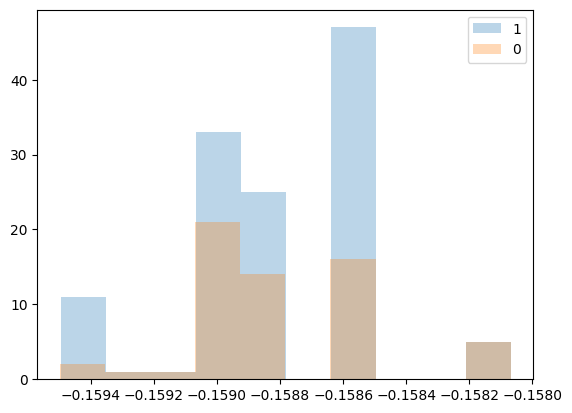

In [50]:
df_with_y, qualitization_vector = quantification_ii(df2, target_col, feature_cols)

In [51]:
df_with_y

,Survived,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,Parch_0,Parch_1,Parch_2,Parch_4,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,y
1,1,True,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,-0.158576-0.000000j
3,1,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,-0.158897-0.000000j
6,0,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,-0.158939-0.000000j
10,1,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,-0.158069-0.000000j
11,1,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,-0.158940-0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,-0.158892-0.000000j
872,0,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,-0.158939-0.000000j
879,1,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,-0.158615-0.000000j
887,1,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,-0.158940-0.000000j


In [52]:
qualitization_vector

array([ 0.25983758-0.j,  0.2592819 -0.j,  0.26066084-0.j,  0.01517273-0.j,
        0.01521564-0.j,  0.01518219-0.j,  0.0152252 -0.j,  0.01804239-0.j,
        0.01804721-0.j,  0.01803905-0.j,  0.01805771-0.j,  0.06043592-0.j,
        0.06043659-0.j, -0.51210799+0.j, -0.51278084+0.j, -0.51242818+0.j])

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def quantification_ii(df, target_col, feature_cols):
    """
    数量化Ⅱ類を実行する関数
    
    Parameters:
    df (pd.DataFrame): 入力データ
    target_col (str): 目的変数（カテゴリ変数）
    feature_cols (list): 特徴量（カテゴリ変数のみ）
    
    Returns:
    pd.DataFrame: 各データの y 値を追加したデータフレーム
    np.array: 変数ごとの数量化ベクトル
    pd.DataFrame: 固有値と各変数の関係を示すデータフレーム
    """
    # カテゴリカル変数をダミー変換
    X = pd.get_dummies(df[[target_col] + feature_cols])
    target_dummies = [col for col in X.columns if col.startswith(target_col + "_")]
    dependent_vars = [col for col in X.columns if col not in target_dummies]

    # 共分散行列の計算
    S_tot = X[dependent_vars].cov(ddof=0)
    
    # 各クラスのデータ数
    class_counts = {cls: X[f'{target_col}_{cls}'].sum() for cls in df[target_col].unique()}
    
    # 各クラスの共分散行列
    S_class = {cls: X[X[f'{target_col}_{cls}'] == 1][dependent_vars].cov(ddof=0) for cls in df[target_col].unique()}
    
    # 群内共分散行列と群間共分散行列
    N_total = sum(class_counts.values())
    S_within = sum(class_counts[cls] * S_class[cls] for cls in class_counts) / N_total
    S_between = S_tot - S_within
    
    # 固有値・固有ベクトルの計算
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_tot).dot(S_between))
    
    # 最大の固有値を持つインデックス
    idx_eta_square = np.argmax(eig_vals)
    qualitization_vector = eig_vecs[:, idx_eta_square]
    
    # 固有値と変数名を紐づけ
    eigenvalue_df = pd.DataFrame({
        'variable': dependent_vars,
        'eigenvalue_contribution': qualitization_vector
    }).sort_values(by='eigenvalue_contribution', key=abs, ascending=False)

    # y値の計算
    df_with_y = pd.concat([df[[target_col]], X[dependent_vars]], axis=1)
    df_with_y['y'] = X[dependent_vars].dot(qualitization_vector)
    
    # 符号調整
    y_means = df_with_y.groupby(target_col, observed=False)['y'].mean()
    if y_means.iloc[0] < y_means.iloc[-1]:
        qualitization_vector = -1 * qualitization_vector
        df_with_y['y'] = - df_with_y['y']
        eigenvalue_df['eigenvalue_contribution'] = -eigenvalue_df['eigenvalue_contribution']

    # 分布をプロット
    for cls in df[target_col].unique():
        plt.hist(df_with_y[df_with_y[target_col] == cls]['y'], alpha=0.3, label=cls)
    
    plt.legend()
    plt.show()
    
    return df_with_y, qualitization_vector, eigenvalue_df


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/numpy/lib/_histograms_impl.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


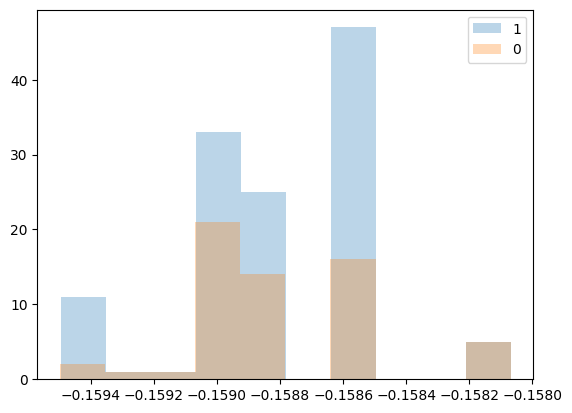

In [54]:
df_with_y, qualitization_vector, eigenvalue_df = quantification_ii(df2, target_col, feature_cols)

In [55]:
eigenvalue_df

,variable,eigenvalue_contribution
14,Embarked_Q,-0.512781-0.000000j
15,Embarked_S,-0.512428-0.000000j
13,Embarked_C,-0.512108-0.000000j
2,Pclass_3,0.260661-0.000000j
0,Pclass_1,0.259838-0.000000j
1,Pclass_2,0.259282-0.000000j
12,Sex_male,0.060437-0.000000j
11,Sex_female,0.060436-0.000000j
10,Parch_4,0.018058-0.000000j
8,Parch_1,0.018047-0.000000j
